In [51]:
import pandas as pd
from pathlib import Path

In [52]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_bootcamp/02_MlFlow/mlruns/1', creation_time=1728846188156, experiment_id='1', last_update_time=1728846188156, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [53]:
DATA = Path("data")
MODELS = Path("models")
train_path = DATA / "green_tripdata_2024-01.parquet"
validation_path = DATA / "green_tripdata_2024-02.parquet"

In [54]:
def load_dataset(path: Path) -> tuple[pd.DataFrame, pd.Series]:
    df = pd.read_parquet(path)
    df["duration"] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60
    df['pickup_location'] = df.PULocationID.astype('string')
    df['dropoff_location'] = df.DOLocationID.astype('string')

    categoricals = ["pickup_location", "dropoff_location"]
    numericals = ["trip_distance"]
    target = "duration"
    outlier_high = df[target].quantile(0.995)
    n_before = df.shape[0]
    df = df[(df[target] < outlier_high)]
    n_after = df.shape[0]

    print(f"Removed {(n_before - n_after) / n_before * 100:.3f}% outliers at threshold {outlier_high}")

    x = df[categoricals + numericals]
    y = df[target]

    return x, y

In [55]:
train_x, train_y = load_dataset(train_path)
val_x, val_y = load_dataset(validation_path)

Removed 0.500% outliers at threshold 94.2875
Removed 0.500% outliers at threshold 108.1053333333338


In [56]:
from sklearn.feature_extraction import DictVectorizer

In [73]:
dv = DictVectorizer()
x = dv.fit_transform(train_x.to_dict(orient="records"))
x_val = dv.transform(val_x.to_dict(orient="records")) # type: ignore

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

with mlflow.start_run():
    mlflow.set_tag("description", "linear regression model to predict NYC taxi duration")
    mlflow.log_param("training dataset", train_path)
    mlflow.log_param("validation dataset", validation_path)

    lr = LinearRegression()
    lr.fit(x, train_y)
    y_pred = lr.predict(x)

    mae: float = mean_absolute_error(train_y, y_pred).item() # type: ignore

    mlflow.log_metric("mae", mae)

<Axes: >

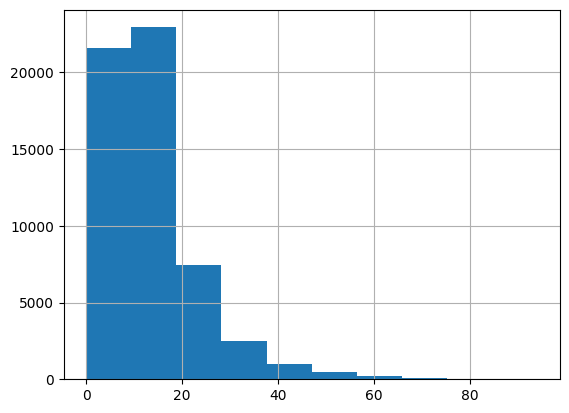

In [59]:
train_y.hist()

In [60]:
import pickle

with open(MODELS/"model.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)


# XGBoost

In [66]:
import xgboost as xgb

In [74]:
dtrain = xgb.DMatrix(x, label=train_y)
dval = xgb.DMatrix(x_val, label=val_y)

In [77]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=250,
            evals=[(dval, "validation")],
            early_stopping_rounds=10
        )

        y_pred = booster.predict(dval)
        mae : float = mean_absolute_error(y_pred=y_pred, y_true=val_y) # type: ignore

        mlflow.log_metric("rmse", mae)

    return {'loss': mae, 'status': STATUS_OK}

In [78]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform("learning_rate", -3, 0),
    'reg_alpha': hp.loguniform("reg_alpha", -5, -1),
    'reg_lambda': hp.loguniform("reg_lambda", -6, -1),
    'min_child_weight': hp.loguniform("min_child_weight", -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

In [79]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials()
)

[0]	validation-rmse:8.92652                           
[1]	validation-rmse:8.01715                           
[2]	validation-rmse:7.46581                           
[3]	validation-rmse:7.13145                           
[4]	validation-rmse:6.92621                           
[5]	validation-rmse:6.80817                           
[6]	validation-rmse:6.73504                           
[7]	validation-rmse:6.68157                           
[8]	validation-rmse:6.64305                           
[9]	validation-rmse:6.60220                           
[10]	validation-rmse:6.58026                          
[11]	validation-rmse:6.55620                          
[12]	validation-rmse:6.53901                          
[13]	validation-rmse:6.52899                          
[14]	validation-rmse:6.51203                          
[15]	validation-rmse:6.49377                          
[16]	validation-rmse:6.48459                          
[17]	validation-rmse:6.47756                          
[18]	valid